# Deploying Flat-Bug

## Flat-bug setup

In [1]:
# Import the main model class
from flat_bug.predictor import Predictor

# Optionally import the set_log_level function to control the verbosity of flat-bug module
# from flat_bug import set_log_level
# set_log_level("DEBUG") # default is "INFO"

## Reproducible tutorial setup
This part is only necessary if you don't have local test files (model weights/images) available. If you have them, you can skip this part.

In [2]:
import os
from urllib.request import urlretrieve

# We have sample weights and image available in a public repo
REMOTE_REPO = "https://anon.erda.au.dk/share_redirect/eU5VZ12Uzj/"

weights = "fb_YOLOv8M-seg.pt"
if not os.path.exists(weights):
    urlretrieve(REMOTE_REPO + "fb_YOLOv8M-seg.pt", weights)
image = "test_image.jpg"
if not os.path.exists(image):
    urlretrieve(REMOTE_REPO + "test_image.jpg", image)

## Basic Usage

In [6]:
# Load the model
model = Predictor(weights, device="cuda:0", dtype="float16")

# Predict
prediction = model.pyramid_predictions(image)

for k, v in prediction.json_data.items():
    v = str(v)
    if len(v) > 100:
        v = v[:100] + "..."
    print(f"{k}: {v}")

YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs
boxes: [[2616, 1648, 2768, 1821], [915, 1589, 1105, 1802], [1394, 815, 1503, 961], [1511, 629, 1612, 767], ...
contours: [[[2707.33349609375, 2704.0, 2702.0, 2700.0, 2698.0, 2695.33349609375, 2683.33349609375, 2672.0, 267...
confs: [0.93505859375, 0.93359375, 0.9248046875, 0.92431640625, 0.91943359375, 0.91796875, 0.9140625, 0.913...
classes: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
scales: [1.0, 1.0, 0.892448874947216, 1.0, 0.892448874947216, 0.892448874947216, 1.0, 1.0, 1.0, 1.0, 1.0, 1....
image_path: test_image.jpg
image_width: 3840
image_height: 2160
mask_width: 3840
mask_height: 2160
identifier: None


## Plot results

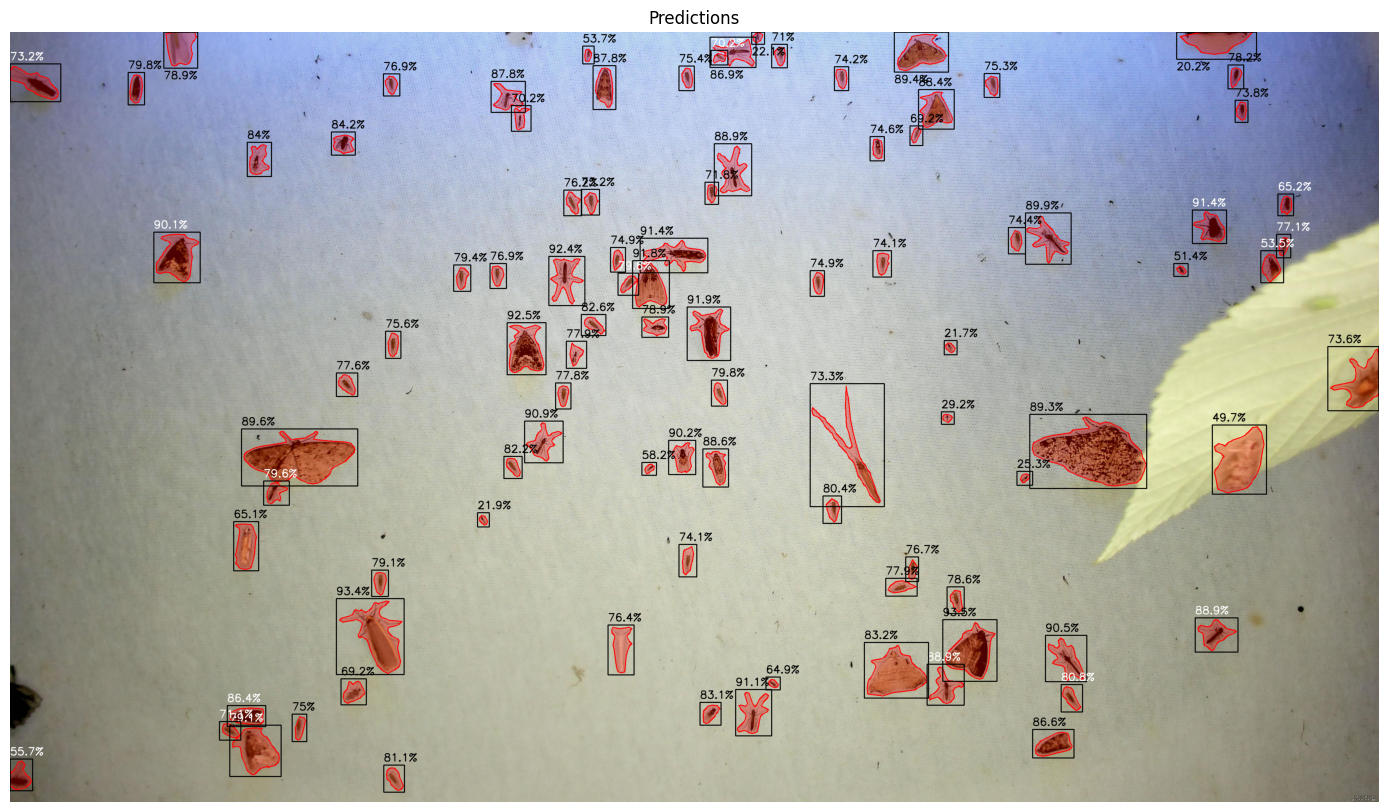

In [4]:
from matplotlib import pyplot as plt

# Plot all the predictions
plt.figure(figsize=(20, 10))
plt.imshow(prediction.plot())
plt.gca().axis("off")
plt.title("Predictions")
plt.show()

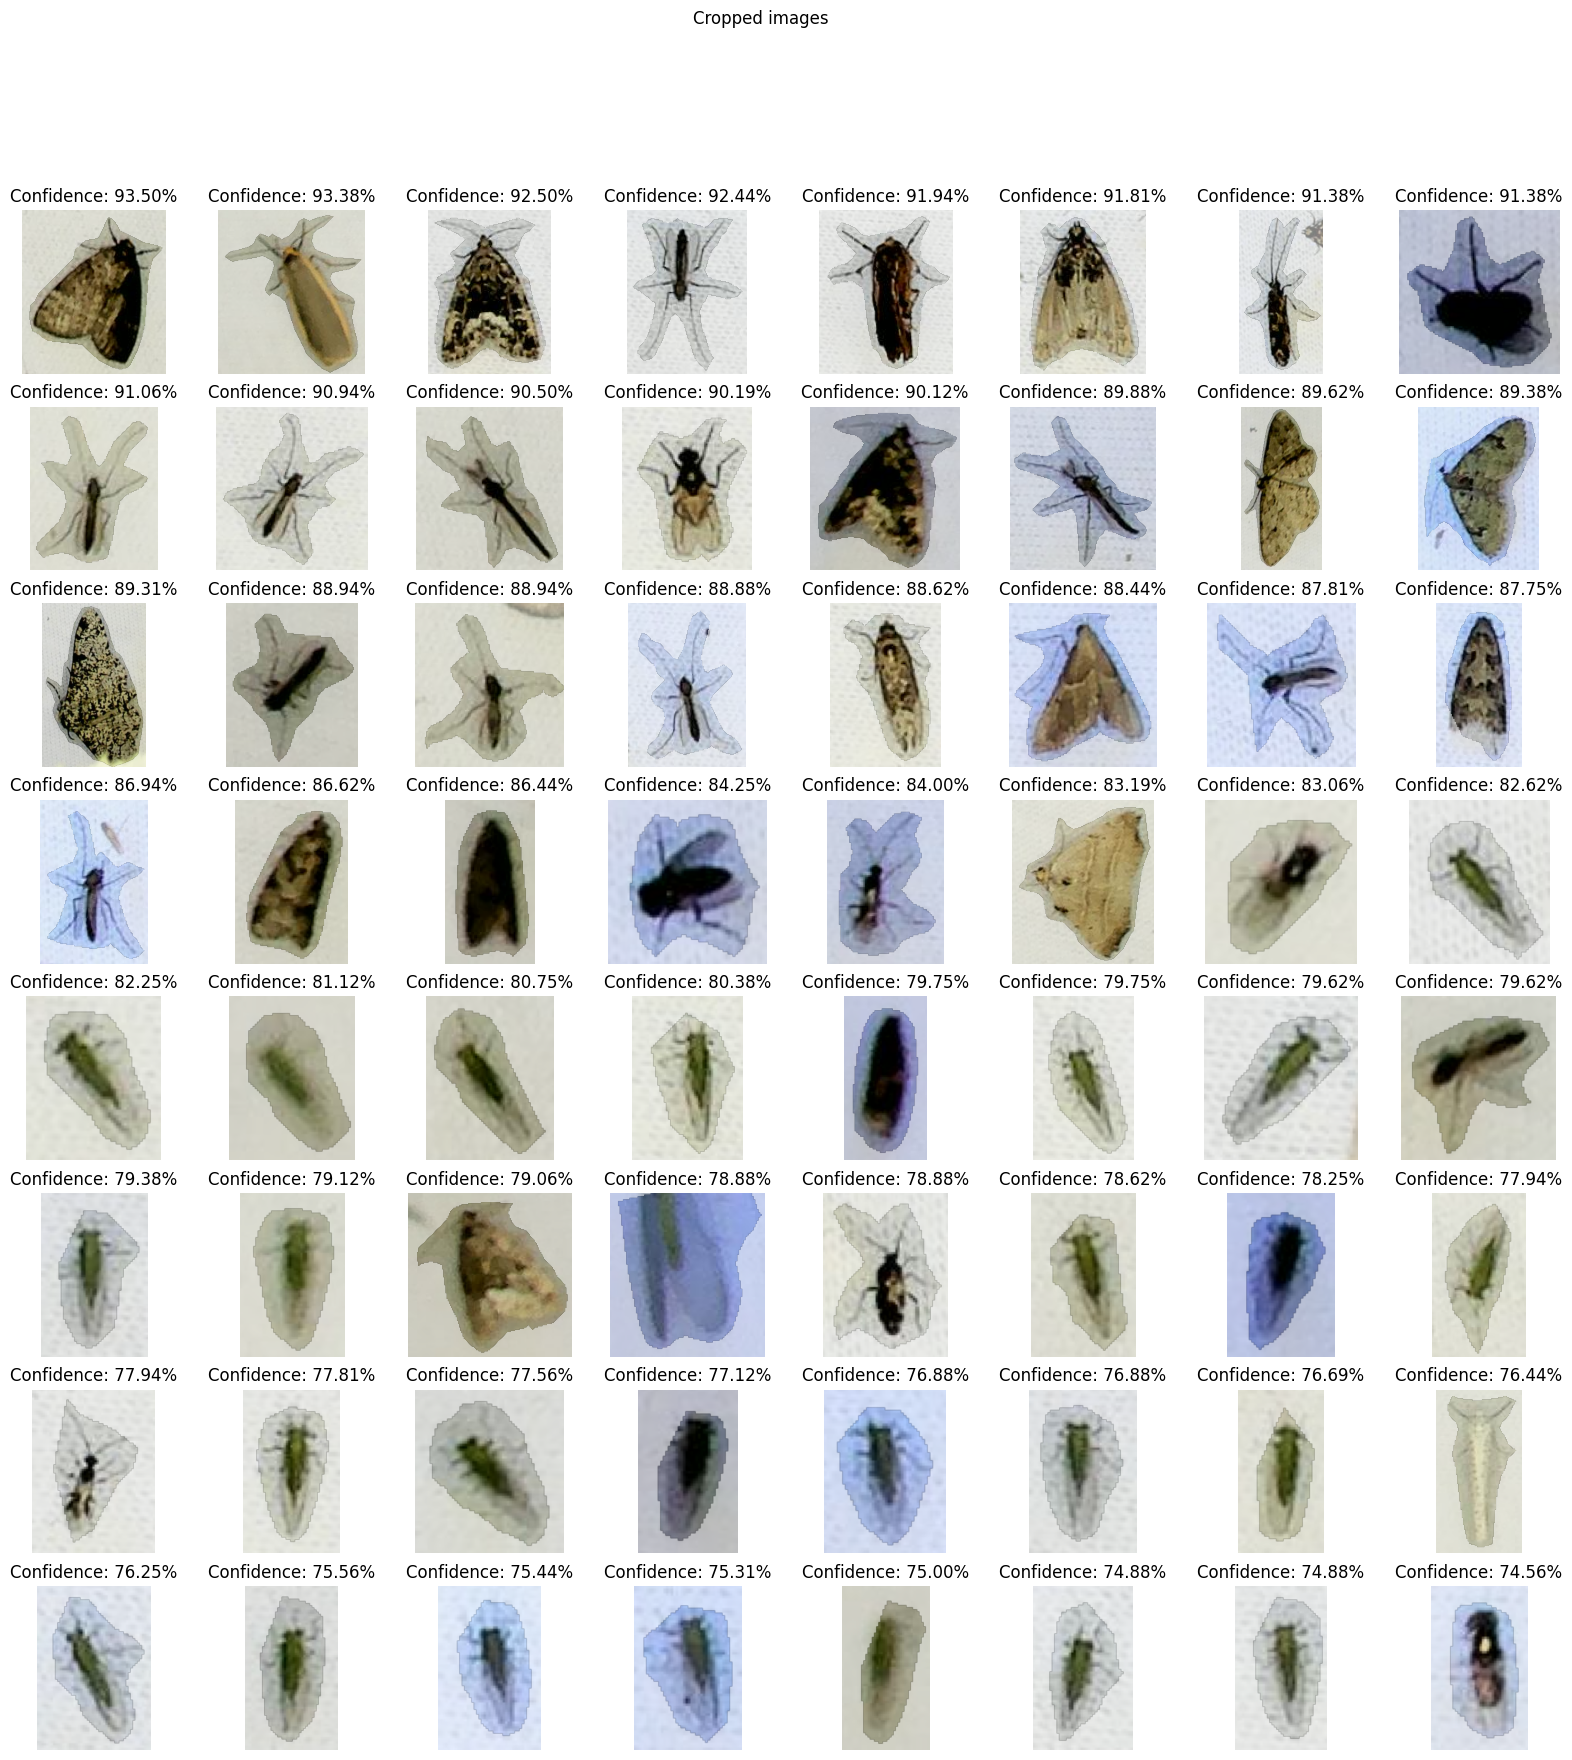

In [5]:
# Plot the cropped images
n_display = min(64, len(prediction))
crops, masks, confidences = prediction.crops[:n_display], prediction.crop_masks[:n_display], prediction.confs[:n_display]

n_crops = len(crops)
ncol = 8
nrow = n_crops // ncol
if n_crops % ncol:
    nrow += 1

fig, axs = plt.subplots(nrow, ncol, figsize=(2.5 * ncol, 2.5 * nrow))
axs = axs.flatten() if n_crops > 1 else [axs]
for ax, crop, mask, conf in zip(axs, crops, masks, confidences):
    crop = crop.permute(1, 2, 0).cpu()
    mask = 1 - mask.squeeze(0).cpu().float()
    w, h = mask.shape
    if w < h:
        mask = mask.transpose(1, 0)
        crop = crop.transpose(1, 0)
    ax.imshow(crop)
    ax.imshow(mask, cmap="gray", vmin=0, vmax=1, alpha=mask * 0.5) 
    ax.set_title(f"Confidence: {conf * 100:.2f}%")
    ax.axis("off")
plt.suptitle("Cropped images")
plt.show()

## Advanced Usage

## Hyperparameters

Timings using the default arguments


2024-09-24 18:01:14 - flat_bug - INFO - Prediction time: 2.968s/85.3% (overhead: 0.3) | Fetch 0.1% | Forward 61.7% | Postprocess 38.2%)
2024-09-24 18:01:17 - flat_bug - INFO - Prediction time: 2.700s/78.7% (overhead: 0.2) | Fetch 0.1% | Forward 60.1% | Postprocess 39.8%)
2024-09-24 18:01:20 - flat_bug - INFO - Prediction time: 2.115s/72.3% (overhead: 0.2) | Fetch 0.1% | Forward 42.3% | Postprocess 57.6%)
2024-09-24 18:01:21 - flat_bug - INFO - Prediction time: 0.664s/69.1% (overhead: 0.6) | Fetch 0.0% | Forward 31.1% | Postprocess 68.9%)
2024-09-24 18:01:21 - flat_bug - INFO - Prediction time: 0.156s/68.1% (overhead: 0.2) | Fetch 0.0% | Forward 60.4% | Postprocess 39.5%)
2024-09-24 18:01:21 - flat_bug - INFO - Total detection time: 11.028s (42.1% forward)
2024-09-24 18:01:23 - flat_bug - INFO - Combining 5 predictions into a single TensorPredictions object took 2.094 s | Duplication removal: 1.874 s | Mask combination: 0.186 s
2024-09-24 18:01:23 - flat_bug - INFO - Initializing Tensor

Timings after manually overriding the pyramid_predictions arguments (scale_before=0.5, single_scale=True)


2024-09-24 18:01:27 - flat_bug - INFO - Prediction time: 0.536s/73.3% (overhead: 0.4) | Fetch 0.0% | Forward 45.0% | Postprocess 55.0%)
2024-09-24 18:01:27 - flat_bug - INFO - Total detection time: 0.732s (32.8% forward)
2024-09-24 18:01:27 - flat_bug - INFO - Combining 1 predictions into a single TensorPredictions object took 0.135 s | Duplication removal: 0.108 s | Mask combination: 0.020 s
2024-09-24 18:01:27 - flat_bug - INFO - Initializing TensorPredictions took 0.136 s
2024-09-24 18:01:27 - flat_bug - INFO - Offsetting, scaling and padding took 0.014 s
2024-09-24 18:01:27 - flat_bug - INFO - Non-maximum suppression took 0.162s for removing 48 elements of 107 elements
2024-09-24 18:01:27 - flat_bug - INFO - Total pyramid time: 1.265s (57.8% detection | 19% forward)


Timings after manually overriding the pyramid_predictions arguments (scale_before=0.5, single_scale=False)


2024-09-24 18:01:31 - flat_bug - INFO - Prediction time: 1.255s/76.3% (overhead: 0.2) | Fetch 0.1% | Forward 41.9% | Postprocess 58.0%)
2024-09-24 18:01:31 - flat_bug - INFO - Prediction time: 0.426s/74.3% (overhead: 0.6) | Fetch 0.0% | Forward 48.1% | Postprocess 51.8%)
2024-09-24 18:01:31 - flat_bug - INFO - Prediction time: 0.165s/88% (overhead: 0.1) | Fetch 0.0% | Forward 39.9% | Postprocess 60.1%)
2024-09-24 18:01:31 - flat_bug - INFO - Total detection time: 2.405s (33% forward)
2024-09-24 18:01:32 - flat_bug - INFO - Combining 3 predictions into a single TensorPredictions object took 0.488 s | Duplication removal: 0.339 s | Mask combination: 0.136 s
2024-09-24 18:01:32 - flat_bug - INFO - Initializing TensorPredictions took 0.490 s
2024-09-24 18:01:32 - flat_bug - INFO - Offsetting, scaling and padding took 0.022 s
2024-09-24 18:01:33 - flat_bug - INFO - Non-maximum suppression took 0.517s for removing 316 elements of 385 elements
2024-09-24 18:01:33 - flat_bug - INFO - Total pyr

Timings after manually overriding the pyramid_predictions arguments (scale_before=0.266, single_scale=False)


2024-09-24 18:01:35 - flat_bug - INFO - Prediction time: 0.404s/73.6% (overhead: 0.6) | Fetch 0.1% | Forward 31.7% | Postprocess 68.2%)
2024-09-24 18:01:35 - flat_bug - INFO - Total detection time: 0.548s (23.2% forward)
2024-09-24 18:01:35 - flat_bug - INFO - Combining 1 predictions into a single TensorPredictions object took 0.151 s | Duplication removal: 0.134 s | Mask combination: 0.011 s
2024-09-24 18:01:35 - flat_bug - INFO - Initializing TensorPredictions took 0.152 s
2024-09-24 18:01:35 - flat_bug - INFO - Offsetting, scaling and padding took 0.013 s
2024-09-24 18:01:35 - flat_bug - INFO - Non-maximum suppression took 0.379s for removing 27 elements of 62 elements
2024-09-24 18:01:35 - flat_bug - INFO - Total pyramid time: 1.222s (44.9% detection | 10.4% forward)


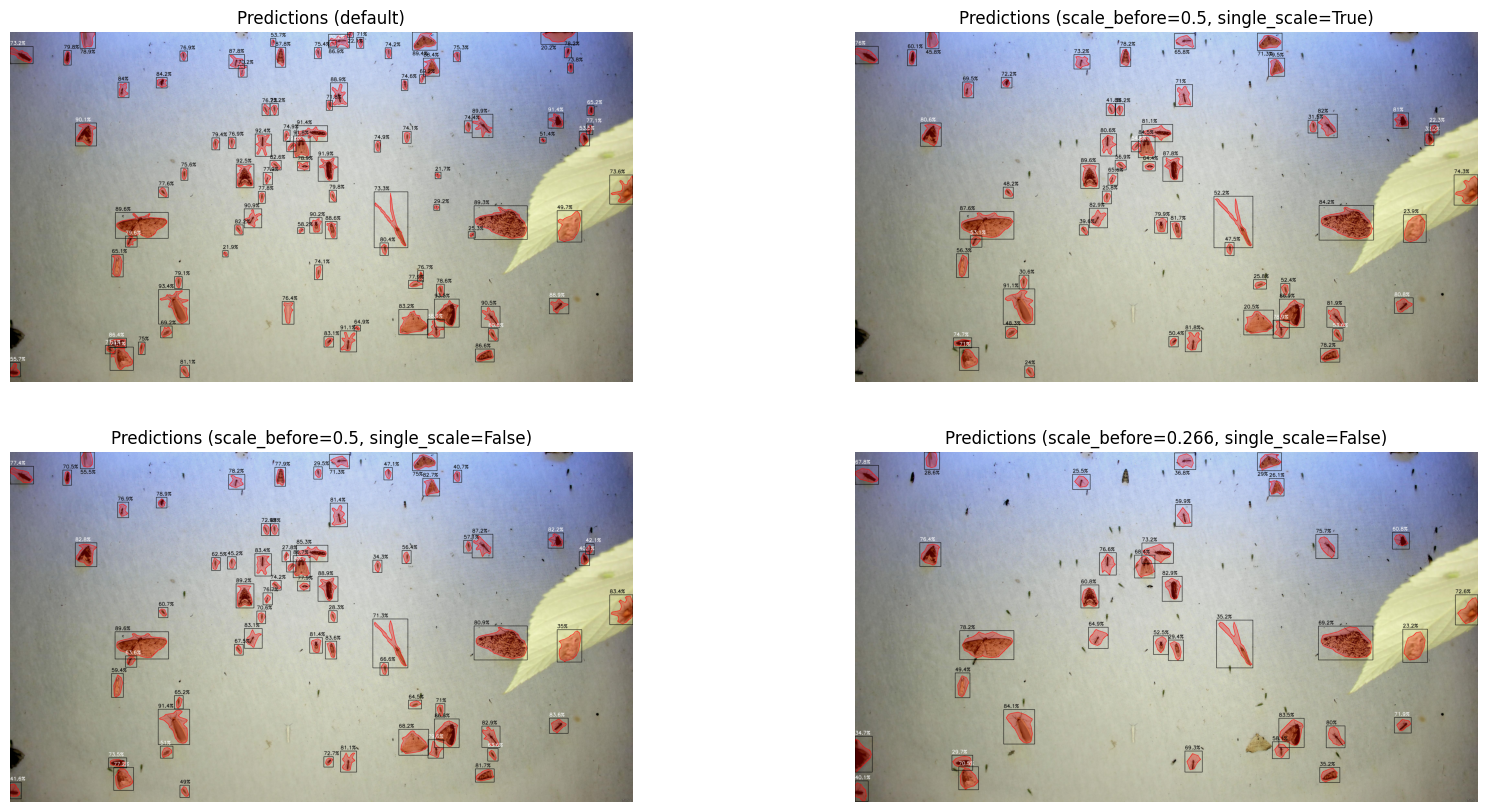

In [22]:
# We can set the model hyperparameters after loading the model with the set_hyperparameters method
model.set_hyperparameters(
    TIME = True,
    # IOU_THRESHOLD, etc. see the documentation for more options
)

# Here I will demonstrate how to use the pyramid_predictions method with custom arguments and compare the timings and results
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()

# Predict with defaults
print("Timings using the default arguments")
axs[0].imshow(model.pyramid_predictions(image).plot()) # Default arguments (scale_before=1.0, single_scale=False)
axs[0].axis("off")
axs[0].set_title("Predictions (default)")

# Predict with custom arguments
print("Timings after manually overriding the pyramid_predictions arguments (scale_before=0.5, single_scale=True)")
axs[1].imshow(model.pyramid_predictions(image, scale_before=0.5, single_scale=True).plot()) # Scale the image down by 50% and only predict at the native level
axs[1].axis("off")
axs[1].set_title("Predictions (scale_before=0.5, single_scale=True)")

print("Timings after manually overriding the pyramid_predictions arguments (scale_before=0.5, single_scale=False)")
axs[2].imshow(model.pyramid_predictions(image, scale_before=0.5, single_scale=False).plot()) # Scale the image down by 50% and tile from there
axs[2].axis("off")
axs[2].set_title("Predictions (scale_before=0.5, single_scale=False)")

print("Timings after manually overriding the pyramid_predictions arguments (scale_before=0.266, single_scale=False)") # Scale the image down such that the largest dimension is smaller than the tile size (1024)
axs[3].imshow(model.pyramid_predictions(image, scale_before=0.266, single_scale=False).plot()) # Scale the image down such that the largest dimension is smaller than the tile size (1024)
axs[3].axis("off")
axs[3].set_title("Predictions (scale_before=0.266, single_scale=False)")

# Show plot
plt.show()